In [15]:
%matplotlib inline
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import caselawnet

[nltk_data] Downloading package punkt to /home/dafne/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
filepath = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/'
links_sub = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-to-case-links.csv'))
cases_sub = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-nodes-sub.csv'))
links_sub_ext = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-to-case-links-ext.csv'))
cases_sub_ext = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-nodes-ext.csv'))

In [16]:
print('Subnetwork: {} nodes, {} links'.format(len(cases_sub), len(links_sub)))
print('Extended subnetwork: {} nodes, {} links'.format(len(cases_sub_ext), len(links_sub_ext)))

Subnetwork: 1596 nodes, 1608 links
Extended subnetwork: 2086 nodes, 2795 links


In [11]:
cases_sub.head()

,ecli,lido_id,country,court,year,id,label,node_type
0,ECLI:NL:CRVB:2016:2999,http://linkeddata.overheid.nl/terms/jurisprude...,NL,CRVB,2016.0,http://linkeddata.overheid.nl/terms/jurisprude...,CRVB:2016,0
1,ECLI:NL:RBROT:2013:BZ2568,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBROT,2013.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBROT:2013,0
2,ECLI:NL:GHAMS:2011:BU6149,http://linkeddata.overheid.nl/terms/jurisprude...,NL,GHAMS,2011.0,http://linkeddata.overheid.nl/terms/jurisprude...,GHAMS:2011,0
3,ECLI:NL:GHARL:2014:6359,http://linkeddata.overheid.nl/terms/jurisprude...,NL,GHARL,2014.0,http://linkeddata.overheid.nl/terms/jurisprude...,GHARL:2014,0
4,ECLI:NL:RBNHO:2017:5966,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBNHO,2017.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBNHO:2017,0


In [12]:
cases_sub_ext.head()

,ecli,lido_id,country,court,year,id,label
0,ECLI:NL:RBARN:2012:BY4763,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBARN,2012.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBARN:2012
1,ECLI:NL:KTGSCH:1997:AG1555,http://linkeddata.overheid.nl/terms/jurisprude...,NL,KTGSCH,1997.0,http://linkeddata.overheid.nl/terms/jurisprude...,KTGSCH:1997
2,ECLI:NL:RBZLY:2006:AY7850,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBZLY,2006.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBZLY:2006
3,ECLI:NL:RBROT:2014:519,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBROT,2014.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBROT:2014
4,ECLI:NL:GHSHE:2013:BZ5085,http://linkeddata.overheid.nl/terms/jurisprude...,NL,GHSHE,2013.0,http://linkeddata.overheid.nl/terms/jurisprude...,GHSHE:2013


In [101]:
def add_network_statistics(nodes, links):
    if len(nodes)==0:
        return nodes
    graph = nx.readwrite.json_graph.node_link_graph({'nodes': nodes, 'links': links}, directed=True, multigraph=False)
    degree = nx.degree(graph)
    if max(dict(degree).values()) > 0:
        hubs, authorities = caselawnet.network_analysis.get_hits(graph)
        statistics = {
            'degree': degree,
            'in_degree': graph.in_degree(),
            'out_degree': graph.out_degree(),

            'degree_centrality': nx.degree_centrality(graph),
            'in_degree_centrality': nx.in_degree_centrality(graph),
            'out_degree_centrality': nx.out_degree_centrality(graph),
            'betweenness_centrality': nx.betweenness_centrality(graph),
            'closeness_centrality': nx.closeness_centrality(graph),
            'pagerank': caselawnet.network_analysis.get_pagerank(graph),
            'hubs': hubs,
            'authorities': authorities
        }
    else:
        statistics = {}
    for i, node in enumerate(nodes):
            nodeid = node['id']
            for var in statistics.keys():
                node[var] = statistics[var][nodeid]
    caselawnet.network_analysis.get_community(graph, nodes)
    return graph, nodes

In [71]:
cases_sub_list = cases_sub.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')
links_sub_list = links_sub.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')

cases_ext_list = cases_sub_ext.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')
links_ext_list = links_sub_ext.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')

In [106]:
g_sub, nodes_sub = add_network_statistics(cases_sub_list, links_sub_list)
g_ext, nodes_ext = add_network_statistics(cases_ext_list, links_ext_list)

In [199]:
nodes_sub_out = [n for n in nodes_sub if n['degree']>0]
nodes_ext_out = [n for n in nodes_ext if n['degree']>0]
for n in nodes_sub_out:
    n['subject'] = 'unknown'
    n['creator'] = n['court']
    n['title'] = n['ecli']
for n in nodes_ext_out:
    n['subject'] = 'unknown'
    n['creator'] = n['court']
    n['title'] = n['ecli']
caselawnet.to_sigma_json(nodes_sub_out, links_sub_list, 'Employer liability', os.path.join(filepath, 'subnetwork', 'network_sub.json'))
caselawnet.to_sigma_json(nodes_ext_out, links_ext_list, 'Employer liability, extended', os.path.join(filepath, 'subnetwork', 'network_sub_ext.json'))

In [197]:
nodes_sub[0]

{'authorities': 0.0,
 'betweenness_centrality': 0.0,
 'closeness_centrality': 0.0,
 'community': '112',
 'country': 'NL',
 'court': 'CRVB',
 'degree': 0,
 'degree_centrality': 0.0,
 'ecli': 'ECLI:NL:CRVB:2016:2999',
 'hubs': 0.0,
 'id': 'http://linkeddata.overheid.nl/terms/jurisprudentie/id/ECLI:NL:CRVB:2016:2999',
 'in_degree': 0,
 'in_degree_centrality': 0.0,
 'label': 'CRVB:2016',
 'lido_id': 'http://linkeddata.overheid.nl/terms/jurisprudentie/id/ECLI:NL:CRVB:2016:2999',
 'node_type': 0,
 'out_degree': 0,
 'out_degree_centrality': 0.0,
 'pagerank': 0.00033191674770152203,
 'year': 2016.0}

In [107]:
nodes_sub_df = pd.DataFrame(nodes_sub)
nodes_ext_df = pd.DataFrame(nodes_ext)

In [109]:
nodes_sub_df.describe()

,authorities,betweenness_centrality,closeness_centrality,degree,degree_centrality,hubs,in_degree,in_degree_centrality,node_type,out_degree,out_degree_centrality,pagerank,year
count,1596.000000,1.596000e+03,1596.000000,1596.000000,1596.000000,1.596000e+03,1596.000000,1596.000000,1596.0,1596.000000,1596.000000,1596.000000,1596.000000
mean,0.000627,5.618921e-07,0.000800,2.015038,0.001263,6.265664e-04,1.007519,0.000632,0.0,1.007519,0.000632,0.000627,2010.541353
std,0.004513,5.842664e-06,0.003858,5.115937,0.003207,2.127889e-03,4.656065,0.002919,0.0,2.057163,0.001290,0.002031,4.390376
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000332,1997.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000332,2008.000000
50%,0.000000,0.000000e+00,0.000000,1.000000,0.000627,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000332,2011.000000
75%,0.000000,0.000000e+00,0.000627,2.000000,0.001254,9.374919e-07,1.000000,0.000627,0.0,1.000000,0.000627,0.000341,2014.000000
max,0.102839,1.394466e-04,0.057183,87.000000,0.054545,2.050058e-02,87.000000,0.054545,0.0,31.000000,0.019436,0.039333,2018.000000


In [193]:
nodes_sub_df.sort_values('authorities', ascending=False)[['ecli', 'authorities']].head(30)

,ecli,authorities
660,ECLI:NL:HR:2008:BD3129,0.102839
915,ECLI:NL:HR:2008:BC9225,0.065130
925,ECLI:NL:HR:2008:BB4767,0.054525
1048,ECLI:NL:HR:2008:BB6175,0.052172
1143,ECLI:NL:HR:2005:AU3313,0.048190
1006,ECLI:NL:HR:2011:BR5223,0.038381
1038,ECLI:NL:HR:2007:BA3017,0.033198
767,ECLI:NL:HR:2009:BH1996,0.031009
1029,ECLI:NL:HR:2011:BR5215,0.029808
876,ECLI:NL:HR:2007:BA7355,0.025526


In [192]:
nodes_sub_df[nodes_sub_df['ecli']=='ECLI:NL:HR:2008:BD1847']

,authorities,betweenness_centrality,closeness_centrality,community,country,court,degree,degree_centrality,ecli,hubs,id,in_degree,in_degree_centrality,label,lido_id,node_type,out_degree,out_degree_centrality,pagerank,year
593,2.566333e-10,0.0,0.057183,9,NL,HR,87,0.054545,ECLI:NL:HR:2008:BD1847,0.0,http://linkeddata.overheid.nl/terms/jurisprude...,87,0.054545,HR:2008,http://linkeddata.overheid.nl/terms/jurisprude...,0,0,0.0,0.028577,2008.0


In [189]:
# What are the highest ranked nodes?
for att in ['in_degree', 'authorities', 'betweenness_centrality']:
    print(att)
    print("subnetwork")
    print(nodes_sub_df.sort_values(att, ascending=False)[['ecli', att]].head()) 
    print('extended')
    print(nodes_ext_df.sort_values(att, ascending=False)[['ecli', att]].head())

in_degree
subnetwork
                           ecli  in_degree
593      ECLI:NL:HR:2008:BD1847         87
660      ECLI:NL:HR:2008:BD3129         63
123   ECLI:NL:RBUTR:2011:BP2283         63
1028     ECLI:NL:HR:2006:AW6166         49
915      ECLI:NL:HR:2008:BC9225         46
extended
                           ecli  in_degree
175      ECLI:NL:HR:2008:BD1847        149
226   ECLI:NL:RBUTR:2011:BP2283        111
2035   ECLI:NL:CRVB:2009:BK3713        105
1384     ECLI:NL:HR:2008:BD3129         65
1790   ECLI:NL:CRVB:2009:BK3717         58
authorities
subnetwork
                        ecli  authorities
660   ECLI:NL:HR:2008:BD3129     0.102839
915   ECLI:NL:HR:2008:BC9225     0.065130
925   ECLI:NL:HR:2008:BB4767     0.054525
1048  ECLI:NL:HR:2008:BB6175     0.052172
1143  ECLI:NL:HR:2005:AU3313     0.048190
extended
                           ecli  authorities
175      ECLI:NL:HR:2008:BD1847     0.510405
226   ECLI:NL:RBUTR:2011:BP2283     0.396910
398      ECLI:NL:HR:2011:BO9570    

In [188]:
# What are the highest ranked nodes?
nodes_ext_df.sort_values('in_degree', ascending=False).head()

,authorities,betweenness_centrality,closeness_centrality,community,country,court,degree,degree_centrality,ecli,hubs,id,in_degree,in_degree_centrality,label,lido_id,out_degree,out_degree_centrality,pagerank,year
175,5.104055e-01,0.000000,0.074898,10,NL,HR,149,0.071463,ECLI:NL:HR:2008:BD1847,0.000000e+00,http://linkeddata.overheid.nl/terms/jurisprude...,149,0.071463,HR:2008,http://linkeddata.overheid.nl/terms/jurisprude...,0,0.000000,0.029732,2008.0
226,3.969102e-01,0.000009,0.052899,10,NL,RBUTR,113,0.054197,ECLI:NL:RBUTR:2011:BP2283,7.517551e-03,http://linkeddata.overheid.nl/terms/jurisprude...,111,0.053237,RBUTR:2011,http://linkeddata.overheid.nl/terms/jurisprude...,2,0.000959,0.022412,2011.0
2035,2.335249e-16,0.000000,0.051570,2,NL,CRVB,105,0.050360,ECLI:NL:CRVB:2009:BK3713,0.000000e+00,http://linkeddata.overheid.nl/terms/jurisprude...,105,0.050360,CRVB:2009,http://linkeddata.overheid.nl/terms/jurisprude...,0,0.000000,0.016221,2009.0
1384,1.633880e-07,0.000086,0.035814,6,NL,HR,69,0.033094,ECLI:NL:HR:2008:BD3129,2.795289e-09,http://linkeddata.overheid.nl/terms/jurisprude...,65,0.031175,HR:2008,http://linkeddata.overheid.nl/terms/jurisprude...,4,0.001918,0.005609,2008.0
1790,7.163630e-17,0.000000,0.030269,2,NL,CRVB,58,0.027818,ECLI:NL:CRVB:2009:BK3717,0.000000e+00,http://linkeddata.overheid.nl/terms/jurisprude...,58,0.027818,CRVB:2009,http://linkeddata.overheid.nl/terms/jurisprude...,0,0.000000,0.012049,2009.0


In [138]:
def networks_per_year(nodes_df, links_list):
    networks = {}

    for year in range(int(min(nodes_df['year'])), int(max(nodes_df['year']))+1):
        nodes_filtered_df = nodes_df[nodes_df['year']<=year]
        nodes_filtered = nodes_filtered_df.to_dict(orient='records')
        links_filtered = [l for l in links_list 
                          if l['source'] in nodes_filtered_df['id'].as_matrix()
                         and l['target'] in nodes_filtered_df['id'].as_matrix()]
        if len(links_filtered) > 0:
            g, nodes_year = add_network_statistics(nodes_filtered.copy(), links_filtered.copy())
            networks[year] = {'nodes': nodes_year, 'edges': links_filtered}

    years = list(networks.keys())
    years.sort()
    nodes_total_df =  pd.concat(
        [pd.DataFrame(networks[year]['nodes']).set_index('ecli') for year in years], keys=years)


    year_stats = pd.DataFrame(index=years)
    year_stats['nr_nodes'] = nodes_total_df.groupby(level=0)['id'].count()
    year_stats['nr_links'] = [len(networks[year]['edges']) for year in year_stats.index]
    for var in ['in_degree', 'out_degree', 'degree', 
                'in_degree_centrality', 'out_degree_centrality', 'degree_centrality',
               'authorities', 'hubs', 'pagerank', 'betweenness_centrality', 'closeness_centrality']:
        year_stats['avg_'+var] = nodes_total_df.groupby(level=0)[var].mean()
        
    return networks, nodes_total_df, year_stats

In [139]:
networks_sub, nodes_years_sub, year_stats_sub = networks_per_year(cases_sub, links_sub_list)

In [140]:
networks_ext, nodes_years_ext, year_stats_ext = networks_per_year(cases_sub_ext, links_ext_list)

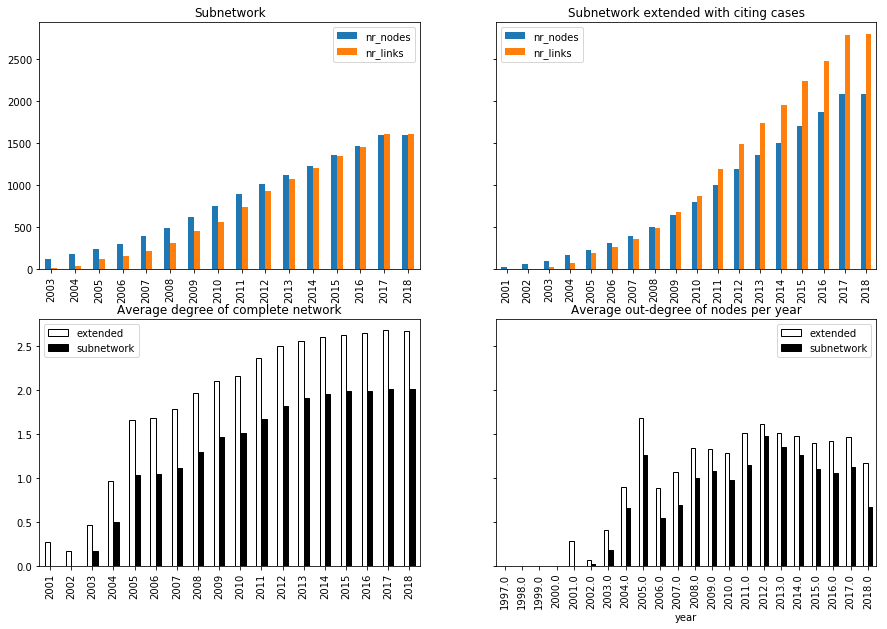

In [177]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharey='row')
year_stats_sub[['nr_nodes', 'nr_links']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Subnetwork')
year_stats_ext[['nr_nodes', 'nr_links']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Subnetwork extended with citing cases')

pd.DataFrame({'subnetwork': year_stats_sub['avg_degree'], 'extended': year_stats_ext['avg_degree']}).plot(ax=axes[1,0], kind='bar', cmap='binary', edgecolor='black')
axes[1,0].set_title('Average degree of complete network')
pd.DataFrame({'subnetwork': nodes_sub_df.groupby('year')['out_degree'].mean(), 
              'extended': nodes_ext_df.groupby('year')['out_degree'].mean()}).plot(ax=axes[1,1], kind='bar', cmap='binary', edgecolor='black')
axes[1,1].set_title('Average out-degree of nodes per year')
plt.show()

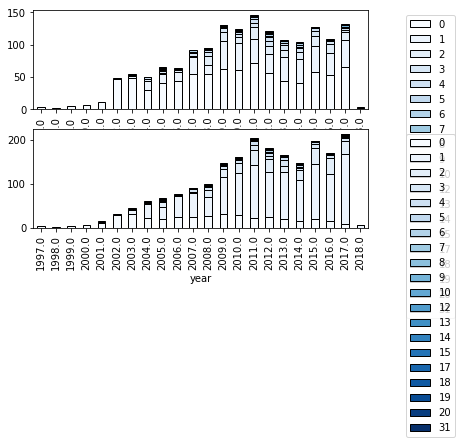

In [124]:
fig, axes = plt.subplots(2)
for i, nodes in enumerate([nodes_sub_df, nodes_ext_df]):
    values = nodes.groupby(['year', 'out_degree']).size().unstack(fill_value=0)
    values.plot(kind='bar', stacked=True, cmap='Blues', linewidth=1, edgecolor='black', ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.1, 1), loc='upper left')